In [1]:
import sys
if not '../..' in sys.path:
    sys.path.append('../..')

from analysis import analysis, plot
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ortho_group
from scipy.linalg import subspace_angles
from sklearn.decomposition import PCA, NMF
from analysis import analysis
from scipy.stats import tukey_hsd

import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams.update({'axes.labelsize': 16})
mpl.rcParams.update({'figure.figsize': (16*0.8,9*0.8)})
mpl.rcParams.update({'axes.facecolor': "white"})
mpl.rcParams.update({'lines.marker': "+"})
mpl.rcParams.update({'lines.linestyle': ""})
mpl.rcParams.update({"axes.spines.left":   True})
mpl.rcParams.update({"axes.spines.bottom": True})
mpl.rcParams.update({"axes.spines.top":    False})
mpl.rcParams.update({"axes.spines.right":  False})

image_path = Path("/Users/spencer/phd/phd/images/basic_results/pca_dimensionality")

%matplotlib inline

### we want to compare subspaces of our data fit with different tools. This is a comparison to build intuition about different subspace "distances" -- grassman, the one used in Yan et al.

https://kristianeschenburg.netlify.app/post/comparing-subspaces/

In [2]:
def total_var(A):
    # samples x variables
    assert A.shape[0] >= A.shape[1]
    return np.trace(np.cov(A.T))

def solla_metric(D1,D2,n_dimensions=2):
    # compute n-dimensional subspace for datasets D1 and D2
    pca1 = PCA(n_dimensions).fit(D1)
    pca2 = PCA(n_dimensions).fit(D2)
    v11 = analysis.variance_fraction_of_projection(pca1.components_,D1)
    # data 2 onto subspace 1 -- variance of data 2 captured by subspace 1
    v21 = analysis.variance_fraction_of_projection(pca1.components_,D2)
    # ratio of variance captured by pca1 of data2 / variance captured by pca1 from data 1
    rv2 = v21 / v11 

    v22 = analysis.variance_fraction_of_projection(pca2.components_,D2)
    # data 1 onto subspace 2 -- variance of data 1 captured by subspace 2 
    v12 = analysis.variance_fraction_of_projection(pca2.components_,D1)
    # ratio of variance captured by pca2 of data1 / variance captured by pca2 from data 2
    rv1 = v12/v22

    # mean ratio -- 1 is 100% of variance
    # subtract 1 to get a residual % of variance "lost" from subspace 1 to subspace 2
    return 1 - np.mean([rv1,rv2])

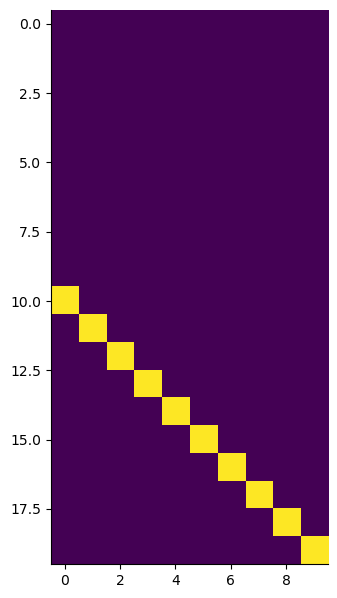

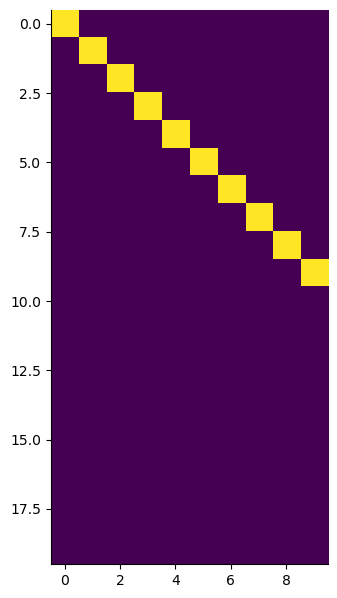

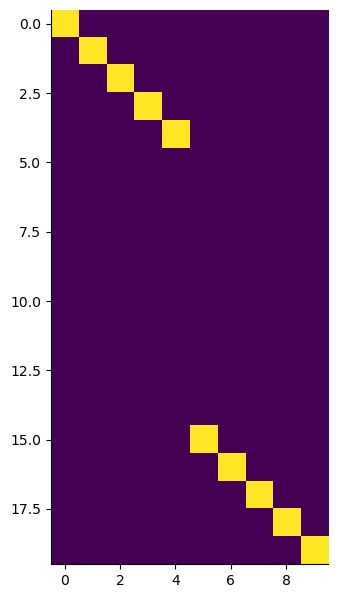

In [3]:
A = np.concatenate([np.zeros(shape=(10,10)),np.eye(10)])
B = np.concatenate([np.roll(np.eye(10),0,axis=1),np.zeros(shape=(10,10))])
C = np.concatenate([np.eye(10)[:5],np.zeros(shape=(10,10)),np.eye(10)[5:]])

# A = np.concatenate([np.random.uniform(0,1,size=(7,10)),np.zeros(shape=(8,10)),np.random.uniform(0,1,size=(0,10))])
# B = np.concatenate([np.random.uniform(0,1,size=(1,10)),np.zeros(shape=(10,10)),np.random.uniform(0,1,size=(4,10))])
# C = np.concatenate([np.random.uniform(0,1,size=(4,10)),np.zeros(shape=(10,10)),np.random.uniform(0,1,size=(1,10))])

plt.figure()
plt.imshow(A)
plt.figure()
plt.imshow(B)
plt.figure()
plt.imshow(C)

In [4]:
d = analysis.grassmann_metric(A,C)
print(d)
d = analysis.grassmann_metric(B,C)
print(d)
d = analysis.grassmann_metric(A,A)
print(d)
d = analysis.grassmann_metric(B,B)
print(d)
d = analysis.grassmann_metric(C,C)
print(d)

0.7071067811865475
0.7071067811865475
0.0
0.0
0.0


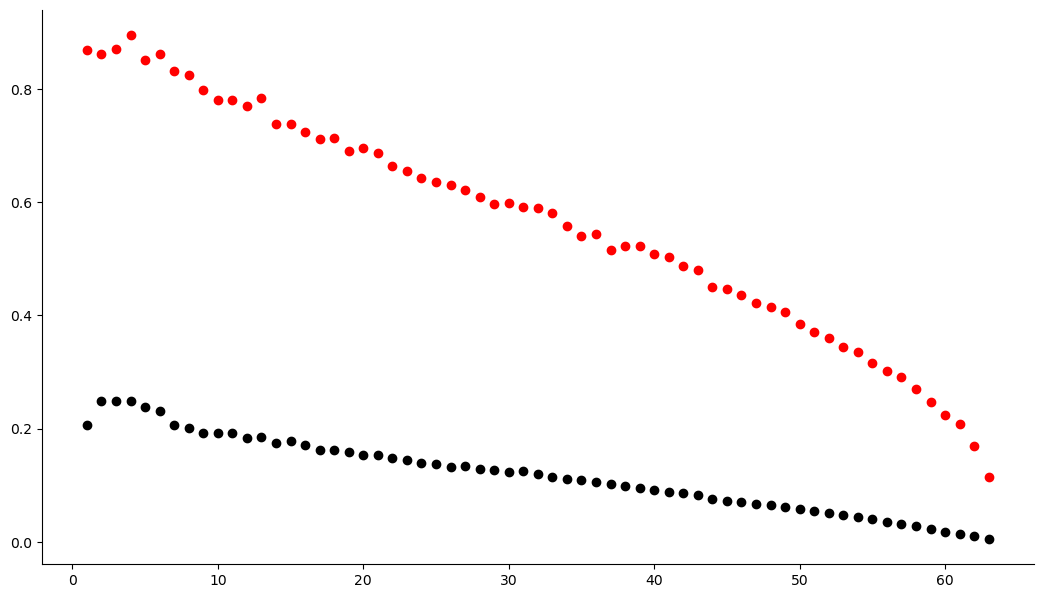

In [5]:
# normal data in different subspaces -- these are non-overlapping or overlapping
nvars = 64
nsamples = 2000

s1 = list(range(nvars)) # [1,2,3,4,5]
D1 = np.zeros(shape=(nsamples, nvars))
n = np.random.multivariate_normal(mean=np.zeros(shape=(len(s1))),cov=np.eye(len(s1)),size=nsamples)
D1[:,s1] = n

s2 = list(range(nvars)) # [11,21,31,41,51]
D2 = np.zeros(shape=(nsamples, nvars))
n = np.random.multivariate_normal(mean=np.ones(shape=(len(s2))),cov=np.eye(len(s1)),size=nsamples)
D2[:,s2] = n

# s3 = [4,5,6,7,8]
# D3 = np.zeros(shape=(nsamples, nvars))
# n = np.random.multivariate_normal(mean=np.zeros(shape=(len(s1))),cov=np.eye(len(s1)),size=nsamples)
# D3[:,s3] = n
for n in range(1,64):
    d = solla_metric(D1,D2,n_dimensions=n)
    plt.plot(n,d,"ko")

    d = analysis.grassmann_metric(PCA(n).fit(D1).components_.T,PCA(n).fit(D2).components_.T)
    plt.plot(n,d,"ro")

In [6]:
np.sqrt(np.sum(np.arccos([np.pi/4,np.pi/4])/(np.pi/2))**2) / 2

0.42491646093308927

`grassman_metric` is a distance -- 0 being parallel, 1 being orthogonal
If the two subspaces share no dimensions in common, they are maximally orthogonal, giving 1
If the two subspaces span the same dimensions, they are maximally parallel, giving 0

Imagine two planes in 3D -- how close are the two planes? The principle angle is essentially the angle between these two planes, generalized to N dimensions!

# compare PCA subspaces? which subspaces?

- take PCA of dimension k for dataset (here we used log transformed data!)
- compare subspaces between datasets w solla and grassman

- which subspaces are we interested in comparing?
    - tasks / chunks (time) -- are these aligned?
        - movement - calibration
        - movement - trial0
        - calibration - trial0
        - trial0 - trial1, etc
    - targets -- do these subspaces become more separated?
        - for each trial chunk,
        - each chunk of same-target trials,
        - pairwise subspace comparison (lower tri distance matrix)
        - take the mean of this? 
    - subjects -- we don't expect subjects to be similar... they have different muscle activation patterns.

In [7]:
subject_idx = 0

In [8]:
movement_stacks = np.load("../subject_filtered_movement_stacks.npy")
movement_stacks.shape

(46, 2, 14, 64, 2000)

In [9]:
calibration_stacks = np.load("../subject_filtered_calibration_stacks.npy")
calibration_stacks.shape

(46, 2, 32, 64, 2400)

In [10]:
chunk_indices = analysis.make_chunk_indices()

# remember to operate on LOG EMG ! for PCA

In [11]:
subject_pca_models = []
for subject_idx in range(46):
    subject_movement_stack = analysis.log_emg_data(analysis.remove_nan_rows(movement_stacks[subject_idx].transpose(0,1,3,2).reshape(-1,64)))
    subject_calibration_stack = analysis.log_emg_data(analysis.remove_nan_rows(calibration_stacks[subject_idx].transpose(0,1,3,2).reshape(-1,64)))

    subject_trial_stack = np.load(f"../filtered_stacks/filtered_stack_{subject_idx}.npy")
    chunk_stacks = []
    for idxs in chunk_indices:
        chunk_stacks.append(analysis.log_emg_data(analysis.remove_nan_rows(subject_trial_stack[idxs[0]:idxs[1]].transpose(0,1,3,2).reshape(-1,64))))

    pca_models = []
    n_components = 3
    for samples in [subject_movement_stack,subject_calibration_stack] + chunk_stacks : 
        pca_models.append(PCA(n_components).fit(samples))
    subject_pca_models.append(pca_models)

cut 1 samples
cut 2 samples
cut 70 samples
cut 2 samples
cut 5 samples
cut 8 samples
cut 3 samples
cut 33 samples
cut 25 samples
cut 54 samples
cut 52 samples


### ~3min runtime

In [12]:
labels = ["Movement\n-\nCalibration", "Movement\n-\nTrial1", "Calibration\n-\nTrial1"] + [f"Trial{n}\n-\nTrial{n+1}" for n in range(1,5)] 
subject_grassmann_metrics = []
for models in subject_pca_models:
    grassmann_metrics = []
    # m-c
    grassmann_metrics.append(analysis.grassmann_metric(models[0].components_.T,models[1].components_.T))
    # m - t1
    grassmann_metrics.append(analysis.grassmann_metric(models[0].components_.T,models[2].components_.T))
    # c - t1
    grassmann_metrics.append(analysis.grassmann_metric(models[1].components_.T,models[2].components_.T))
    # tn - tn+1
    grassmann_metrics.append(analysis.grassmann_metric(models[2].components_.T,models[3].components_.T))
    grassmann_metrics.append(analysis.grassmann_metric(models[3].components_.T,models[4].components_.T))
    grassmann_metrics.append(analysis.grassmann_metric(models[4].components_.T,models[5].components_.T))
    grassmann_metrics.append(analysis.grassmann_metric(models[5].components_.T,models[6].components_.T))

    subject_grassmann_metrics.append(grassmann_metrics)

subject_solla_metrics = []
for subject_idx in range(46):
    subject_movement_stack = analysis.remove_nan_rows(movement_stacks[subject_idx].transpose(0,1,3,2).reshape(-1,64))
    subject_calibration_stack = analysis.remove_nan_rows(calibration_stacks[subject_idx].transpose(0,1,3,2).reshape(-1,64))
    subject_trial_stack = np.load(f"../filtered_stacks/filtered_stack_{subject_idx}.npy")
    chunk_stacks = []
    for idxs in chunk_indices:
        chunk_stacks.append(analysis.remove_nan_rows(subject_trial_stack[idxs[0]:idxs[1]].transpose(0,1,3,2).reshape(-1,64)))

    solla_metrics = []
    # m-c
    solla_metrics.append(solla_metric(subject_movement_stack,subject_calibration_stack))
    # m - t1
    solla_metrics.append(solla_metric(subject_movement_stack,chunk_stacks[0]))
    # c - t1
    solla_metrics.append(solla_metric(subject_calibration_stack,chunk_stacks[1]))
    # tn - tn+1
    solla_metrics.append(solla_metric(chunk_stacks[0],chunk_stacks[1]))
    solla_metrics.append(solla_metric(chunk_stacks[1],chunk_stacks[2]))
    solla_metrics.append(solla_metric(chunk_stacks[2],chunk_stacks[3]))
    solla_metrics.append(solla_metric(chunk_stacks[3],chunk_stacks[4]))
    subject_solla_metrics.append(solla_metrics)

In [13]:
subject_solla_metrics = np.array(subject_solla_metrics)
subject_grassmann_metrics = np.array(subject_grassmann_metrics)
subject_solla_metrics.shape,subject_grassmann_metrics.shape

((46, 7), (46, 7))

(<Figure size 1500x800 with 2 Axes>, (<Axes: >, <Axes: >))

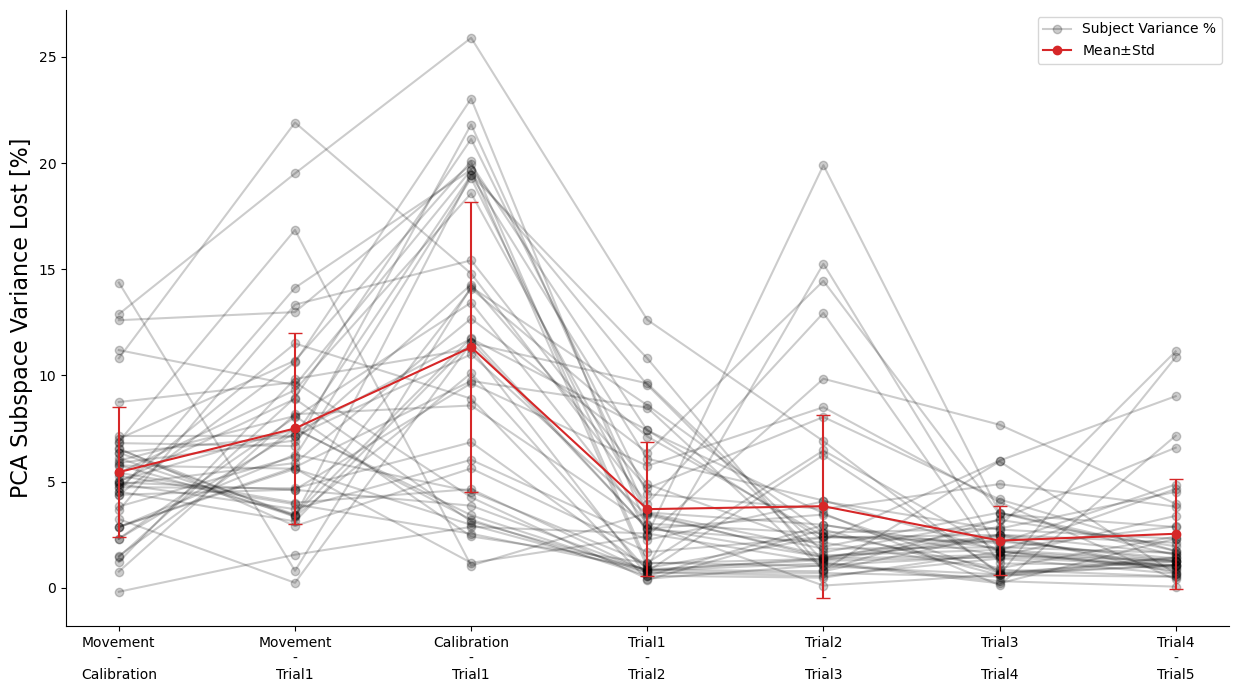

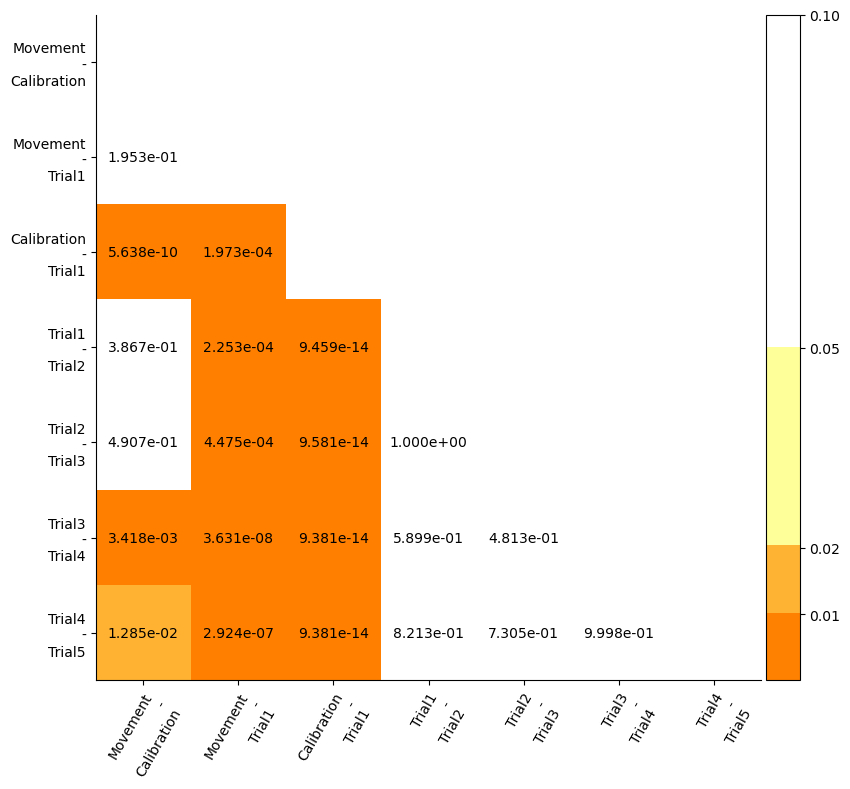

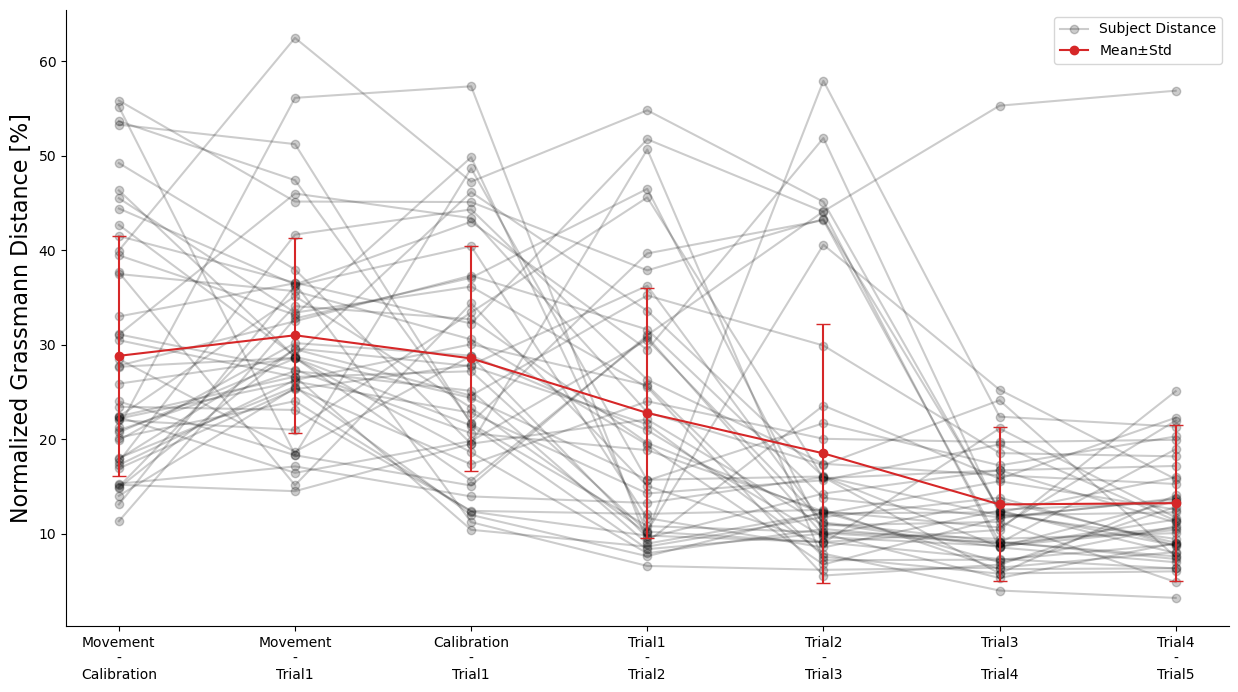

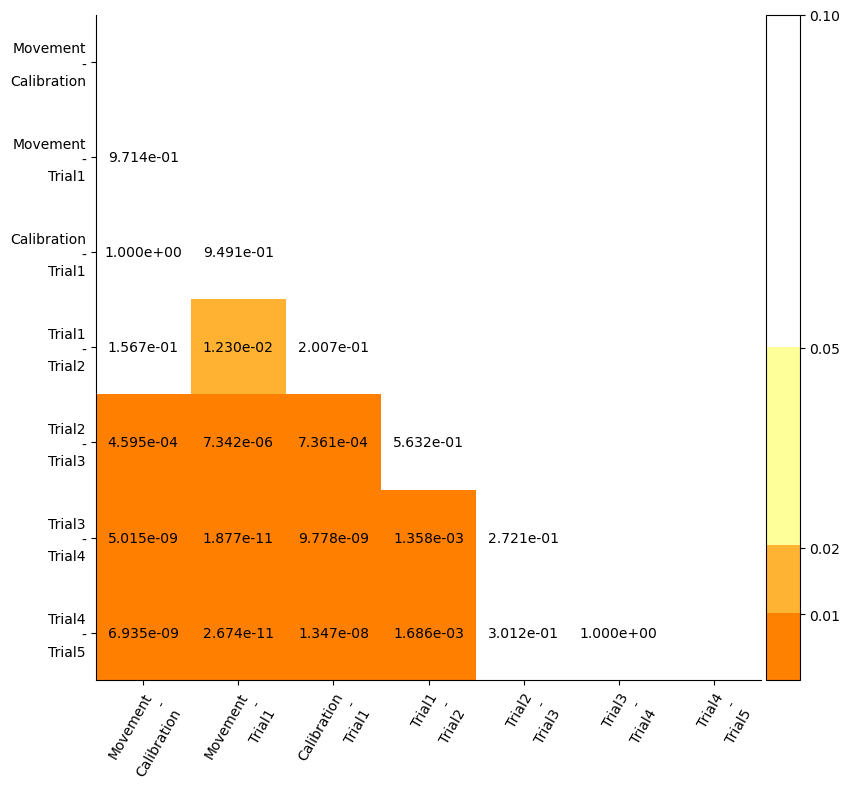

In [14]:
# fig, axes = plt.subplots(ncols=6, nrows=4, figsize=(6*3.5,4*3.5))

# # remove the underlying axes
# for ax in axes.ravel():
#     gs = ax.get_gridspec()
#     ax.remove()

# so_ax = fig.add_subplot(gs[:2, :4])
# so_sig = fig.add_subplot(gs[:2, 4:])
# gr_ax = fig.add_subplot(gs[2:, :4])
# gr_sig = fig.add_subplot(gs[2:, 4:])

so_fig, so_ax = plt.subplots(1,1, figsize=(15,8))
so_sig_fig, so_sig_ax = plt.subplots(1,1, figsize=(15,8))
gr_fig, gr_ax = plt.subplots(1,1, figsize=(15,8))
gr_sig_fig, gr_sig_ax = plt.subplots(1,1, figsize=(15,8))

handles1 = []
h = so_ax.plot(range(7),100*subject_solla_metrics.T,"ko",linestyle="-",alpha=0.2)
handles1.append(h[0])
h = so_ax.errorbar(range(7),100*np.mean(subject_solla_metrics.T,axis=1),100*np.std(subject_solla_metrics.T,axis=1),color="tab:red",marker="o",linestyle="-",capsize=5)
handles1.append(h[0])

handles2 = []
h = gr_ax.plot(range(7),100*subject_grassmann_metrics.T,"ko",linestyle="-",alpha=0.2)
handles2.append(h[0])
h = gr_ax.errorbar(range(7),100*np.mean(subject_grassmann_metrics.T,axis=1),100*np.std(subject_grassmann_metrics.T,axis=1),color="tab:red",marker="o",linestyle="-",capsize=5)
handles2.append(h[0])

legend_labels_so = ["Subject Variance %","Mean$\pm$Std"]
so_ax.set_ylabel("PCA Subspace Variance Lost [%]")
so_ax.legend(handles=handles1,labels=legend_labels_so)
so_ax.set_xticks(range(7))
# so_ax.set_xticklabels([])
so_ax.set_xticklabels(labels)

legend_labels_gr = ["Subject Distance","Mean$\pm$Std"]
gr_ax.set_ylabel("Normalized Grassmann Distance [%]")
gr_ax.legend(handles=handles2,labels=legend_labels_gr)
gr_ax.set_xticks(range(7))
gr_ax.set_xticklabels(labels)

result = tukey_hsd(*subject_solla_metrics.T)
plot.annotated_heatmap(result.pvalue,labels_x=labels,labels_y=labels,figax=(so_sig_fig,so_sig_ax))

result = tukey_hsd(*subject_grassmann_metrics.T)
plot.annotated_heatmap(result.pvalue,labels_x=labels,labels_y=labels,figax=(gr_sig_fig,gr_sig_ax))

In [15]:
plot.save_figure(so_fig, "solla_models", image_path, format="pdf")
plot.save_figure(so_sig_fig, "solla_models_significance", image_path, format="png")
plot.save_figure(gr_fig, "grassmann_models", image_path, format="pdf")
plot.save_figure(gr_sig_fig, "grassmann_models_significance", image_path, format="png")

Figure saved to /Users/spencer/phd/phd/images/basic_results/pca_dimensionality/solla_models.pdf
Figure saved to /Users/spencer/phd/phd/images/basic_results/pca_dimensionality/solla_models_significance.png
Figure saved to /Users/spencer/phd/phd/images/basic_results/pca_dimensionality/grassmann_models.pdf
Figure saved to /Users/spencer/phd/phd/images/basic_results/pca_dimensionality/grassmann_models_significance.png


# now try NMF! just use grassmann. do NOT log EMG! (~10min runtime)

In [16]:
subject_nmf_models = []
n_components = 4
for subject_idx in range(46):
    subject_movement_stack = np.abs(analysis.remove_nan_rows(movement_stacks[subject_idx].transpose(0,1,3,2).reshape(-1,64)))
    subject_calibration_stack = np.abs(analysis.remove_nan_rows(calibration_stacks[subject_idx].transpose(0,1,3,2).reshape(-1,64)))

    subject_trial_stack = np.load(f"../filtered_stacks/filtered_stack_{subject_idx}.npy")
    chunk_stacks = []
    for idxs in chunk_indices:
        chunk_stacks.append(np.abs(analysis.remove_nan_rows(subject_trial_stack[idxs[0]:idxs[1]].transpose(0,1,3,2).reshape(-1,64))))

    nmf_models = []
    for samples in [subject_movement_stack, subject_calibration_stack] + chunk_stacks : 
        nmf_models.append(NMF(n_components).fit(samples))
    subject_nmf_models.append(nmf_models)

/opt/homebrew/Caskroom/miniconda/base/envs/data_fix/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/data_fix/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/data_fix/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/data_fix/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/data_fix/lib/python3.11/site-

In [18]:
subject_grassmann_metrics_nmf = []
for models in subject_nmf_models:
    grassmann_metrics_nmf = []
    # m-c
    grassmann_metrics_nmf.append(analysis.grassmann_metric(models[0].components_.T,models[1].components_.T))
    # m - t1
    grassmann_metrics_nmf.append(analysis.grassmann_metric(models[0].components_.T,models[2].components_.T))
    # c - t1
    grassmann_metrics_nmf.append(analysis.grassmann_metric(models[1].components_.T,models[2].components_.T))
    # tn - tn+1
    grassmann_metrics_nmf.append(analysis.grassmann_metric(models[2].components_.T,models[3].components_.T))
    grassmann_metrics_nmf.append(analysis.grassmann_metric(models[3].components_.T,models[4].components_.T))
    grassmann_metrics_nmf.append(analysis.grassmann_metric(models[4].components_.T,models[5].components_.T))
    grassmann_metrics_nmf.append(analysis.grassmann_metric(models[5].components_.T,models[6].components_.T))

    subject_grassmann_metrics_nmf.append(grassmann_metrics_nmf)

subject_grassmann_metrics_nmf = np.array(subject_grassmann_metrics_nmf)
subject_grassmann_metrics_nmf.shape

(46, 7)

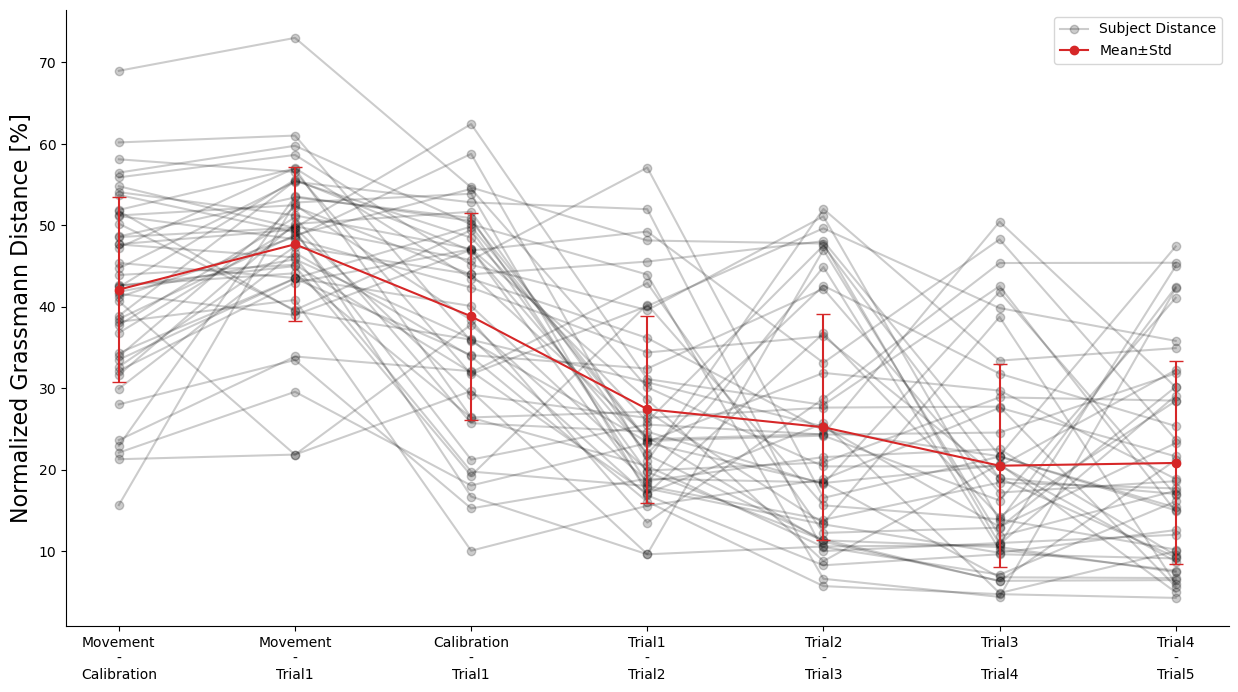

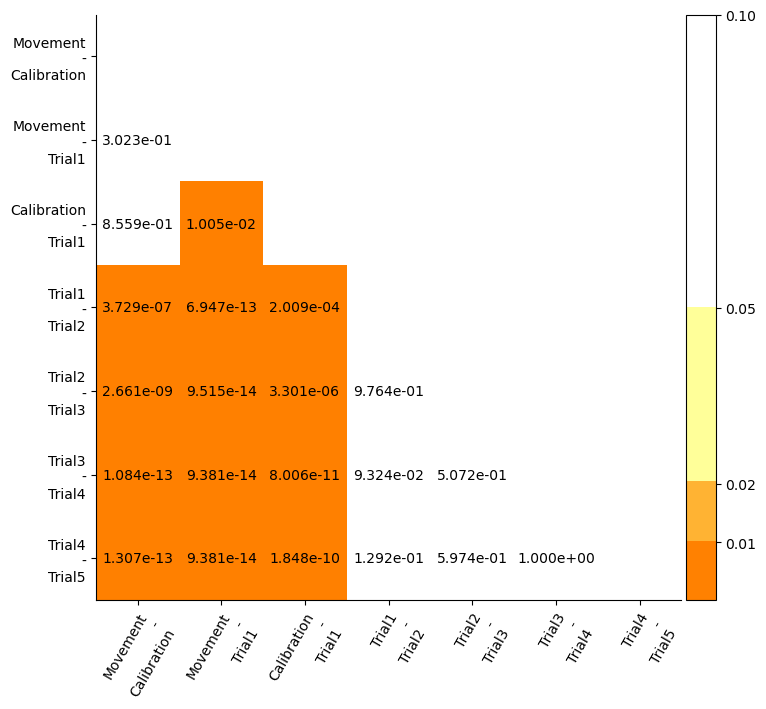

In [21]:
gr_nmf_fig, gr_nmf_ax = plt.subplots(1,1,figsize=(15,8))

handles = []
h = gr_nmf_ax.plot(range(7),100*subject_grassmann_metrics_nmf.T,"ko",linestyle="-",alpha=0.2)
handles.append(h[0])
h = gr_nmf_ax.errorbar(range(7),100*np.mean(subject_grassmann_metrics_nmf.T,axis=1),np.std(100*subject_grassmann_metrics_nmf.T,axis=1),color="tab:red",marker="o",linestyle="-",capsize=5)
handles.append(h[0])

legend_labels_gr = ["Subject Distance","Mean$\pm$Std"]
gr_nmf_ax.set_ylabel("Normalized Grassmann Distance [%]")
gr_nmf_ax.legend(handles=handles,labels=legend_labels_gr)
gr_nmf_ax.set_xticks(range(7))
gr_nmf_ax.set_xticklabels(labels)

result = tukey_hsd(*subject_grassmann_metrics_nmf.T)
gr_nmf_sig_fig, _ = plot.annotated_heatmap(result.pvalue,labels_x=labels,labels_y=labels)

In [22]:
plot.save_figure(gr_nmf_fig, "gr_nmf", image_path, format="pdf")
plot.save_figure(gr_nmf_sig_fig, "gr_nmf_sig", image_path, format="png")

Figure saved to /Users/spencer/phd/phd/images/basic_results/pca_dimensionality/gr_nmf.pdf
Figure saved to /Users/spencer/phd/phd/images/basic_results/pca_dimensionality/gr_nmf_sig.png
